In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import json
import os
from os import listdir
from os.path import isfile, join
from pycocotools import mask as _mask
import torch

from h_json import *
from h_detectron2 import *
from h_cutler import *

p = 4
plt.rcParams['figure.figsize'] = [1.5*p,p]

## Initialization

#### Path to datasets, annotations

In [2]:
# path to data/annotations in "system" format
syspath="/home/dkhatanassia/detectron2_dataset"

#*************************************** datasets *****************************************
dataset_train = 'jerry_real'
dataset_test = 'jerry_real'
DPI = 50
#******************************************************************************************

# root
root_train = join(syspath,dataset_train)
root_test = join(syspath,dataset_test)

# path to images{train, test}
imgs_train = join(root_train,'imgs')
imgs_test = join(root_test,'_imgs')

# path to json{train, test}
json_name_GT = f'GT_{dataset_test}.json'
json_name_GT_tr = f'tr_GT_{dataset_train}.json'
json_name_GT_te = f'te_GT_{dataset_test}.json'
json_name_mc = f'mc_{dataset_test}.json'
json_name_mc_tr = f'tr_mc_{dataset_train}.json'
json_name_mc_te = f'te_mc_{dataset_test}.json'

json_path_GT = join(root_test,'annotations',json_name_GT)
json_path_GT_tr = join(root_train,'annotations',json_name_GT_tr)
json_path_GT_te = join(root_test,'annotations',json_name_GT_te)
json_path_mc = join(root_test,'annotations',json_name_mc)
json_path_mc_tr = join(root_train,'annotations',json_name_mc_tr)
json_path_mc_te = join(root_test,'annotations',json_name_mc_te)

# builtin datasets location
%cd ~/CutLER/cutler
os.environ['DETECTRON2_DATASETS']='/home/dkhatanassia/CutLER/cutler/datasets'
print(os.getenv('DETECTRON2_DATASETS'))

/home/dkhatanassia/CutLER/cutler
/home/dkhatanassia/CutLER/cutler/datasets


#### Register datasets to detectron2

In [3]:
# register datasets
d2name = [
    json_name_GT,
    json_name_GT_tr,
    json_name_GT_te,
    json_name_mc,
    json_name_mc_tr,
    json_name_mc_te]

d2imgs = [
    imgs_test,
    imgs_train,
    imgs_test,
    imgs_test,
    imgs_train,
    imgs_test]

d2json = [
    json_path_GT,
    json_path_GT_tr,
    json_path_GT_te,
    json_path_mc,
    json_path_mc_tr,
    json_path_mc_te]

for key in range(len(d2name)):
    if not os.path.exists(d2json[key]): continue
    registerCatalog(d2name[key],d2json[key],d2imgs[key])

registered: GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/tr_GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/tr_mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_mc_jerry_real.json
json 

#### Path to weights, outputs, ...

In [4]:
# current round
rnd = 4

# path to output for current round
p2o = join(root_train,f'rd{rnd-1}-{rnd}')
if not os.path.exists(p2o):
    os.makedirs(p2o)
    print(f'created: {p2o}\n')
    
p2cfg = 'model_zoo/configs/CutLER-ImageNet/real_cascade_mask_rcnn_R_50_FPN.yaml'
#p2w = '/home/dkhatanassia/CutLER/cutler/weights/jerry_sp10.pth'


#**** ANNOTATIONS *****
# path to new predictions
p2np =join(p2o,'inference/coco_instances_results.json')
# path to previous json
p2pj_tr = json_path_mc_tr
p2pj_te = json_path_mc_te

dict_path = {
    'config':p2cfg,
    'output':p2o,
    'new predictions':p2np,
    'prev json_tr':p2pj_tr,
    'prev json_te': p2pj_te}

print(f'ROUND: {rnd}')
[print(f'path to {d}: {dict_path[d].replace(root_train,".")}') for d in dict_path]


ROUND: 4
path to config: model_zoo/configs/CutLER-ImageNet/real_cascade_mask_rcnn_R_50_FPN.yaml
path to output: ./rd3-4
path to new predictions: ./rd3-4/inference/coco_instances_results.json
path to prev json_tr: ./annotations/tr_mc_jerry_real.json
path to prev json_te: ./annotations/te_mc_jerry_real.json


[None, None, None, None, None]

#### RGB mean std 

In [8]:
means = []
stds = []

image_paths = [join(imgs_train,f) for f in listdir(imgs_train) if f.endswith('.jpg')]

for idx in range(0,len(image_paths),50):
    sub = image_paths[idx:idx+50]
    tmp = np.array([cv2.imread(im,cv2.IMREAD_COLOR) for im in sub])
    mean = np.mean(tmp, axis=(0, 1, 2))
    std = np.std(tmp, axis=(0, 1, 2))
    
    means.append(mean)
    stds.append(std)
    
mean=np.mean(np.vstack(means),axis=0)
std=np.mean(np.vstack(stds),axis=0)

print(f'RGB mean: {mean}\nRGB std: {std}')

RGB mean: [89.64660327 90.67840797 85.66147834]
RGB std: [71.10338834 69.38465503 70.38432146]


#### Generate pseudo GT (use mc files)

In [9]:
dpi = 50
th = 0.95

In [ ]:
# train - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_mc_tr}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
OUTPUT_DIR '{p2o}'
# train - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_tr}'  \
--save-path '{p2pj_tr}' \
--threshold '{th}'

/home/dkhatanassia/detectron2_dataset/jerry_real/annotations/tr_mc_jerry_real.json contains 6433 annotations, but only 6098 of them match to images in the file.


registered: tr_mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/tr_mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs



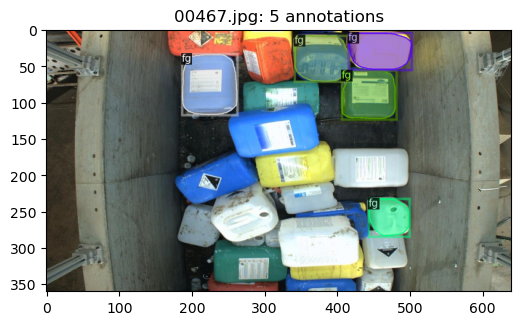

In [10]:
registerCatalog(json_name_mc_tr,json_path_mc_tr,imgs_train)
visualizeSample(417, json_name_mc_tr)

In [ ]:
# test - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_mc_te}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
OUTPUT_DIR '{p2o}'
# test - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_te}'  \
--save-path '{p2pj_te}' \
--threshold '{th}'

registered: te_mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs



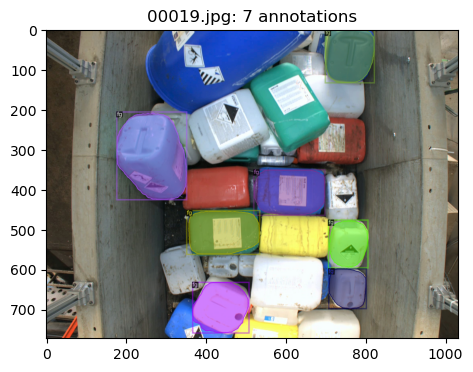

In [11]:
registerCatalog(json_name_mc_te,json_path_mc_te,imgs_test)
visualizeSample(5, json_name_mc_te)

## DropLoss4: weights(jerry_sp10_rd3) -> train to get weights(4)

In [12]:
torch.cuda.empty_cache()
infos=torch.cuda.memory_summary()
print(str(infos))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

#### Train

In [ ]:
!rm '{join(p2o,'metrics.json')}'

%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
  --config-file '{p2cfg}'\
  --train-dataset '{json_name_mc_tr}' \
  --test-dataset '{json_name_GT_te}' \
  OUTPUT_DIR '{p2o}'

#### Plot some info about training

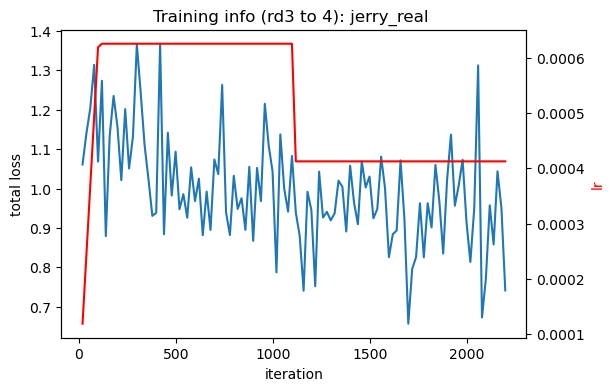

In [13]:
p2w = join(p2o,'model_final.pth')
p2t = join(p2o,f'eval_{rnd-1}to{rnd}')
os.makedirs(p2t,exist_ok=True)
plotTrainingInfo(p2o,p2t,rnd,dataset_train)

#### Test intermediate weights

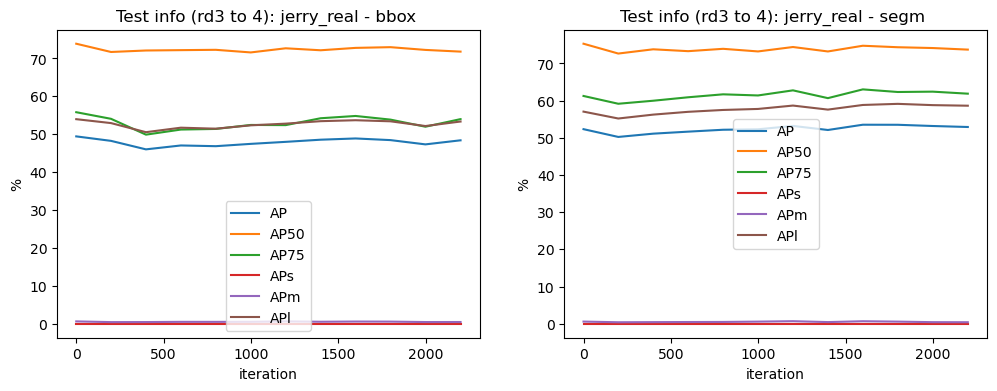

In [14]:
iter_inter = 200
iter_final = 2200
tmp_test = json_name_GT_te
tmp_cfg = 'model_zoo/configs/CutLER-ImageNet/real_cascade_mask_rcnn_R_50_FPN.yaml'

from helper import init_df, get_results
df_bbox = init_df(p2o)
df_segm = init_df(p2o)
    
if not os.path.exists(join(p2t,'bbox.csv')):
    nb_weights = len([d for d in listdir(p2o) if '.pth' in d])
    for i in range(nb_weights+1):
        if i==0: 
            # initial
            value = 0
            %cd ~/CutLER/cutler
            %run train_net.py --num-gpus 1 \
            --config-file '{tmp_cfg}' \
            --test-dataset '{tmp_test}'\
            --eval-only TEST.DETECTIONS_PER_IMAGE '{DPI}'\
            OUTPUT_DIR '{p2t}'
        else:
            # checkpoints
            if i<nb_weights: 
                if value == 0: value+=iter_inter-1
                else: value+=iter_inter
                weights_tested = join(p2o,f'model_{str(value).zfill(7)}.pth')
            # final
            else:
                value = iter_final
                weights_tested = p2w
        
            %cd ~/CutLER/cutler
            %run train_net.py --num-gpus 1 \
            --config-file '{tmp_cfg}' \
            --test-dataset '{tmp_test}'\
            --eval-only TEST.DETECTIONS_PER_IMAGE '{DPI}'\
            MODEL.WEIGHTS '{weights_tested}' \
            OUTPUT_DIR '{p2t}'
            
        get_results(p2t,df_bbox,df_segm,value)
    
    df_bbox['CP_nb']=df_bbox['CP_nb'].astype(int)
    df_segm['CP_nb']=df_segm['CP_nb'].astype(int)
    # save csv
    df_bbox.to_csv(join(p2t,'bbox.csv'), index=False)
    df_segm.to_csv(join(p2t,'segm.csv'), index=False)
    
plotTestInfo(p2t,rnd,dataset_test)

#### Test DPI and th

In [15]:
p2dpith = join(p2o,'DPI_th')

DPIs = [1,5,10,50]
ths = [0.01] + list(np.arange(0.5,1,0.05).round(2)) + [0.99]

##### generate jsons

In [ ]:
for dpi in DPIs:
    %cd ~/CutLER/cutler
    %run train_net.py --num-gpus 1 \
    --config-file '{p2cfg}' \
    --test-dataset '{json_name_mc_te}'\
    --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}'\
    MODEL.WEIGHTS '{p2w}' \
    OUTPUT_DIR '{p2dpith}'
        
    for tmp_th in ths:
        tmp_pred = join(p2dpith,'inference','coco_instances_results.json')
        tmp_rnd_name = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{tmp_th}.json'
        tmp_new = join(p2dpith,tmp_rnd_name)
    
        %cd ~/CutLER/cutler/tools
        %run get_self_training_ann.py \
        --new-pred '{tmp_pred}' \
        --prev-ann '{p2pj_te}'  \
        --save-path '{tmp_new}' \
        --threshold '{tmp_th}'

1143


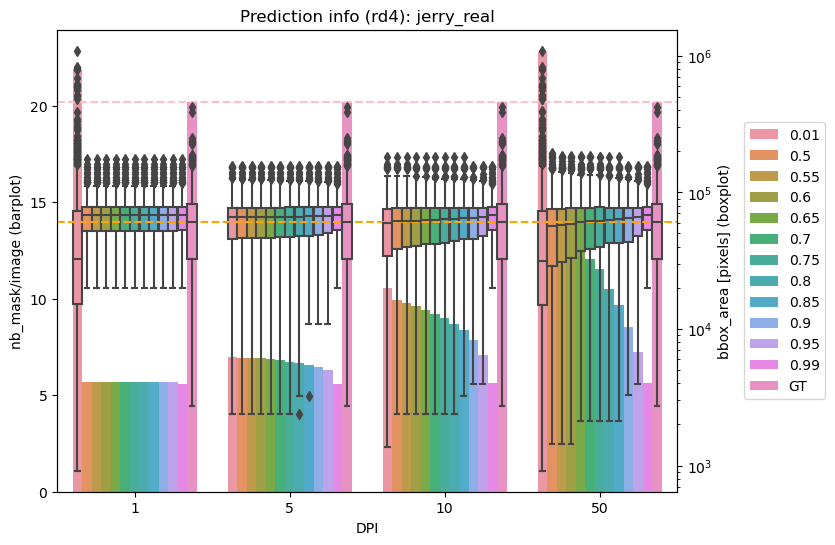

In [16]:
plotDPIthInfo(p2dpith,rnd,DPIs,ths,dataset_test,json_path_GT_te)

#### Generate new predictions based on results, threshold them

In [17]:
dpi = 50
th = 0.95

rnd_name_tr = f'tr_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
p2nj_tr = join(p2o,rnd_name_tr)

rnd_name_te = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
p2nj_te = join(p2o,rnd_name_te)

In [ ]:
# train - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_mc_tr}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
MODEL.WEIGHTS '{p2w}' \
OUTPUT_DIR '{p2o}'
# train - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_tr}'  \
--save-path '{p2nj_tr}' \
--threshold '{th}'

In [ ]:
# test - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_mc_te}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
MODEL.WEIGHTS '{p2w}' \
OUTPUT_DIR '{p2o}'
# test - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_te}'  \
--save-path '{p2nj_te}' \
--threshold '{th}'

#### Register new pseudoGT

In [18]:
# register datasets
d2name = [rnd_name_tr,rnd_name_te]
d2imgs = [imgs_train,imgs_test]
d2json = [p2nj_tr,p2nj_te]

for key in range(len(d2name)):
    registerCatalog(d2name[key],d2json[key],d2imgs[key])

registered: tr_jerry_real_rd4_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd3-4/tr_jerry_real_rd4_DPI50_th0.95.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_jerry_real_rd4_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd3-4/te_jerry_real_rd4_DPI50_th0.95.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs



#### Visualize change in pseudo GT

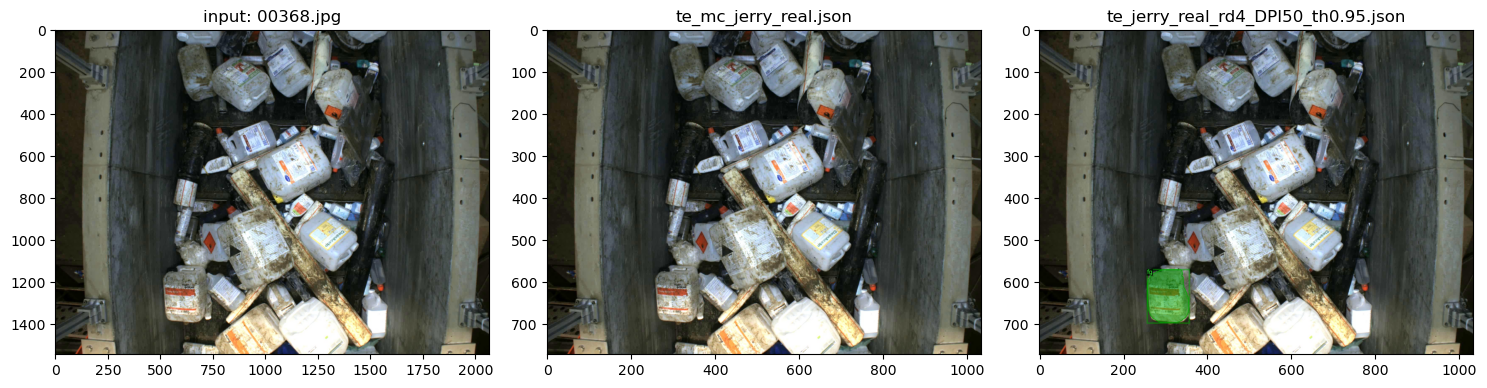

In [19]:
saveto = join(p2o, 'visu')
os.makedirs(saveto,exist_ok=True)
visualizePseudoGT(49, json_name_mc_te,rnd_name_te,p=15,saveto=False)

#### Move to next round

In [20]:
# current round
rnd = 5

# path to output for current round
p2o = join(root_train,f'rd{rnd-1}-{rnd}')
    
if not os.path.exists(p2o):
    os.makedirs(p2o)
    print(f'created: {p2o}\n')
    
#**** ANNOTATIONS *****
# path to new predictions
p2np =join(p2o,'inference/coco_instances_results.json')

# path to previous json
prev_rnd_name_tr = rnd_name_tr
prev_rnd_name_te = rnd_name_te 

p2pj_tr = p2nj_tr
p2pj_te = p2nj_te

dict_path = {
    'config':p2cfg,
    'output':p2o,
    'weigths':p2w,
    'new predictions':p2np,
    'prev json_tr':p2pj_tr,
    'prev json_te': p2pj_te}

print(f'ROUND: {rnd}')
[print(f'path to {d}: {dict_path[d].replace(root_train,".")}') for d in dict_path]


ROUND: 5
path to config: model_zoo/configs/CutLER-ImageNet/real_cascade_mask_rcnn_R_50_FPN.yaml
path to output: ./rd4-5
path to weigths: ./rd3-4/model_final.pth
path to new predictions: ./rd4-5/inference/coco_instances_results.json
path to prev json_tr: ./rd3-4/tr_jerry_real_rd4_DPI50_th0.95.json
path to prev json_te: ./rd3-4/te_jerry_real_rd4_DPI50_th0.95.json


[None, None, None, None, None, None]

## DropLoss5: weights(4) -> train to get weights(5)

#### Train

In [ ]:
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
  --config-file '{p2cfg}' \
  --train-dataset '{prev_rnd_name_tr}' \
  --test-dataset '{json_name_GT_te}' \
    MODEL.WEIGHTS '{p2w}' \
  OUTPUT_DIR '{p2o}'

#### Plot some info about training

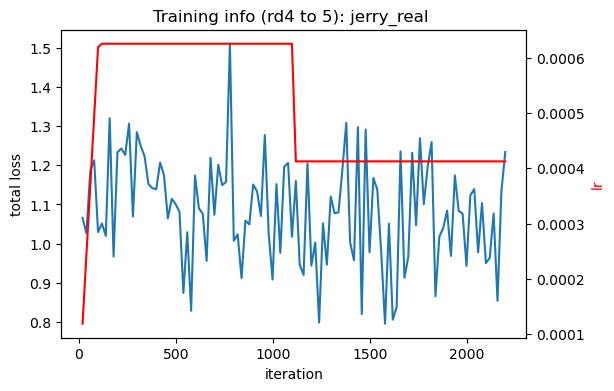

In [21]:
p2w = join(p2o,'model_final.pth')
p2t = join(p2o,f'eval_{rnd-1}to{rnd}')
os.makedirs(p2t,exist_ok=True)
plotTrainingInfo(p2o,p2t,rnd,dataset_train)

#### Test intermediate weights

In [22]:
iter_inter = 200
iter_final = 2200
tmp_test = json_name_GT_te
tmp_cfg = 'model_zoo/configs/CutLER-ImageNet/real_cascade_mask_rcnn_R_50_FPN.yaml'
tmp_p2pw = p2w.replace(f'rd{rnd-1}-{rnd}',f'rd{rnd-2}-{rnd-1}')

tmp_p2pw

'/home/dkhatanassia/detectron2_dataset/jerry_real/rd3-4/model_final.pth'

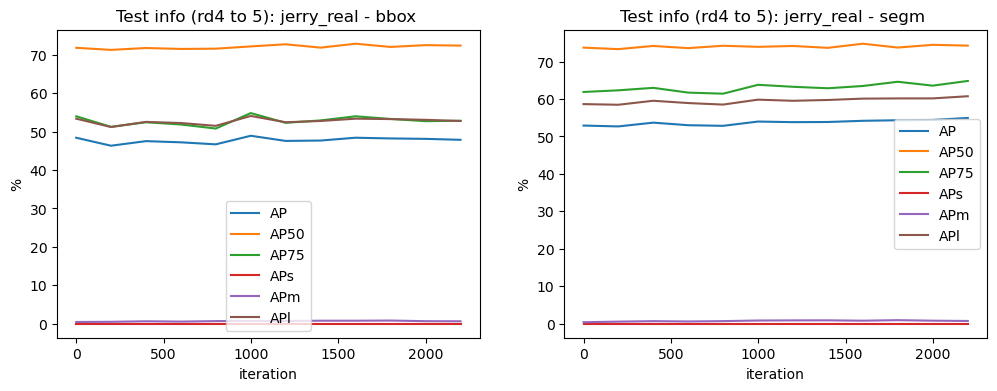

In [23]:
from helper import init_df, get_results
df_bbox = init_df(p2o)
df_segm = init_df(p2o)
    
if not os.path.exists(join(p2t,'bbox.csv')):
    nb_weights = len([d for d in listdir(p2o) if '.pth' in d])
    for i in range(nb_weights+1):
        if i==0: 
            # initial
            value = 0
            %cd ~/CutLER/cutler
            %run train_net.py --num-gpus 1 \
            --config-file '{tmp_cfg}' \
            --test-dataset '{tmp_test}'\
            --eval-only TEST.DETECTIONS_PER_IMAGE '{DPI}'\
            MODEL.WEIGHTS '{tmp_p2pw}' \
            OUTPUT_DIR '{p2t}'
        else:
            # checkpoints
            if i<nb_weights: 
                if value == 0: value+=iter_inter-1
                else: value+=iter_inter
                weights_tested = join(p2o,f'model_{str(value).zfill(7)}.pth')
            # final
            else:
                value = iter_final
                weights_tested = p2w
        
            %cd ~/CutLER/cutler
            %run train_net.py --num-gpus 1 \
            --config-file '{tmp_cfg}' \
            --test-dataset '{tmp_test}'\
            --eval-only TEST.DETECTIONS_PER_IMAGE '{DPI}'\
            MODEL.WEIGHTS '{weights_tested}' \
            OUTPUT_DIR '{p2t}'
            
        get_results(p2t,df_bbox,df_segm,value)
    
    df_bbox['CP_nb']=df_bbox['CP_nb'].astype(int)
    df_segm['CP_nb']=df_segm['CP_nb'].astype(int)
    # save csv
    df_bbox.to_csv(join(p2t,'bbox.csv'), index=False)
    df_segm.to_csv(join(p2t,'segm.csv'), index=False)
    
plotTestInfo(p2t,rnd,dataset_test)

#### Test DPI and th

In [24]:
p2dpith = join(p2o,'DPI_th')

DPIs = [1,5,10,50]
ths = [0.01] + list(np.arange(0.5,1,0.05).round(2)) + [0.99]

##### generate jsons

In [ ]:
for dpi in DPIs:
    %cd ~/CutLER/cutler
    %run train_net.py --num-gpus 1 \
    --config-file '{p2cfg}' \
    --test-dataset '{prev_rnd_name_te}'\
    --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}'\
    MODEL.WEIGHTS '{p2w}' \
    OUTPUT_DIR '{p2dpith}'
        
    for tmp_th in ths:
        tmp_pred = join(p2dpith,'inference','coco_instances_results.json')
        tmp_rnd_name = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{tmp_th}.json'
        tmp_new = join(p2dpith,tmp_rnd_name)
    
        %cd ~/CutLER/cutler/tools
        %run get_self_training_ann.py \
        --new-pred '{tmp_pred}' \
        --prev-ann '{p2pj_te}'  \
        --save-path '{tmp_new}' \
        --threshold '{tmp_th}'

1029


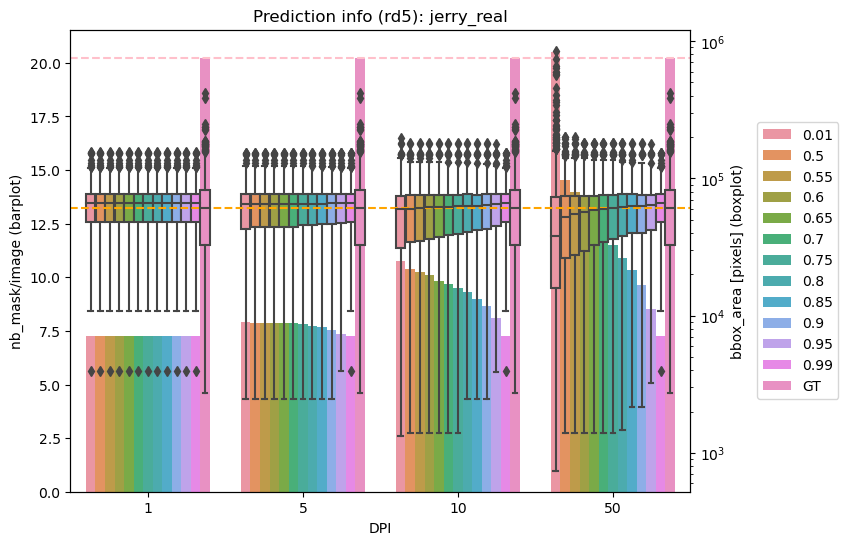

In [25]:
plotDPIthInfo(p2dpith,rnd,DPIs,ths,dataset_test,json_path_GT_te)

#### Generate new predictions based on results, threshold them

In [26]:
dpi = 50
th = 0.9

rnd_name_tr = f'tr_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
p2nj_tr = join(p2o,rnd_name_tr)

rnd_name_te = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
p2nj_te = join(p2o,rnd_name_te)

In [ ]:
# train - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_mc_tr}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
MODEL.WEIGHTS '{p2w}' \
OUTPUT_DIR '{p2o}'
# train - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_tr}'  \
--save-path '{p2nj_tr}' \
--threshold '{th}'

In [ ]:
# test - generate using dpi
%cd ~/CutLER/cutler
%run train_net.py --num-gpus 1 \
--config-file '{p2cfg}' \
--test-dataset '{json_name_mc_te}' \
--eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
MODEL.WEIGHTS '{p2w}' \
OUTPUT_DIR '{p2o}'
# test - threshold
%cd ~/CutLER/cutler/tools
%run get_self_training_ann.py \
--new-pred '{p2np}' \
--prev-ann '{p2pj_te}'  \
--save-path '{p2nj_te}' \
--threshold '{th}'

#### Register new pseudoGT

In [27]:
# register datasets
d2name = [rnd_name_tr,rnd_name_te]
d2imgs = [imgs_train,imgs_test]
d2json = [p2nj_tr,p2nj_te]

for key in range(len(d2name)):
    registerCatalog(d2name[key],d2json[key],d2imgs[key])

registered: tr_jerry_real_rd5_DPI50_th0.9.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd4-5/tr_jerry_real_rd5_DPI50_th0.9.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_jerry_real_rd5_DPI50_th0.9.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd4-5/te_jerry_real_rd5_DPI50_th0.9.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs



#### Visualize change in pseudo GT

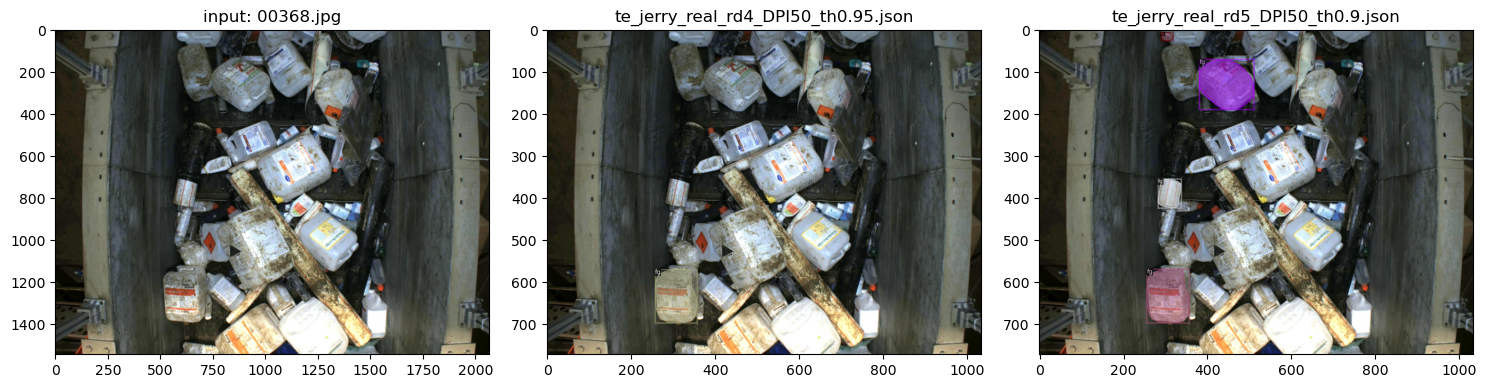

In [28]:
saveto = join(p2o, 'visu')
os.makedirs(saveto,exist_ok=True)
visualizePseudoGT(49, prev_rnd_name_te,rnd_name_te,p=15,saveto=saveto)

## Conclude

In [3]:
rnd = 5

In [4]:
def mergeCSVss(root_train,rnd,iter_inter,offset=0):
    tmp_loc = join(root_train,'gathered')
    for j in ['bbox','segm']:
        start_ = 1 if offset ==0 else offset
        for i in range(start_,rnd+1):
            if i==start_:
                pre = pd.read_csv(join(tmp_loc,f'{j}{i-1}-{i}.csv'))
            else:
                curr = pd.read_csv(join(tmp_loc,f'{j}{i-1}-{i}.csv'))
                pre = pd.concat([pre[:-1],curr[1:]],axis=0)
                
        pre.reset_index(drop=True,inplace=True)
        df_merge = pre[:-1]
        df_merge['CP_nb'] = [0]+[i*iter_inter-1 for i in range(1,df_merge.shape[0])]
        df_merge.to_csv(join(tmp_loc,f'{j}_merged.csv'), index=False)

/home/dkhatanassia/drives/Gdrive/notShared/python/CutLER.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['CP_nb'] = [0]+[i*iter_inter-1 for i in range(1,df_merge.shape[0])]
/home/dkhatanassia/drives/Gdrive/notShared/python/CutLER.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['CP_nb'] = [0]+[i*iter_inter-1 for i in range(1,df_merge.shape[0])]


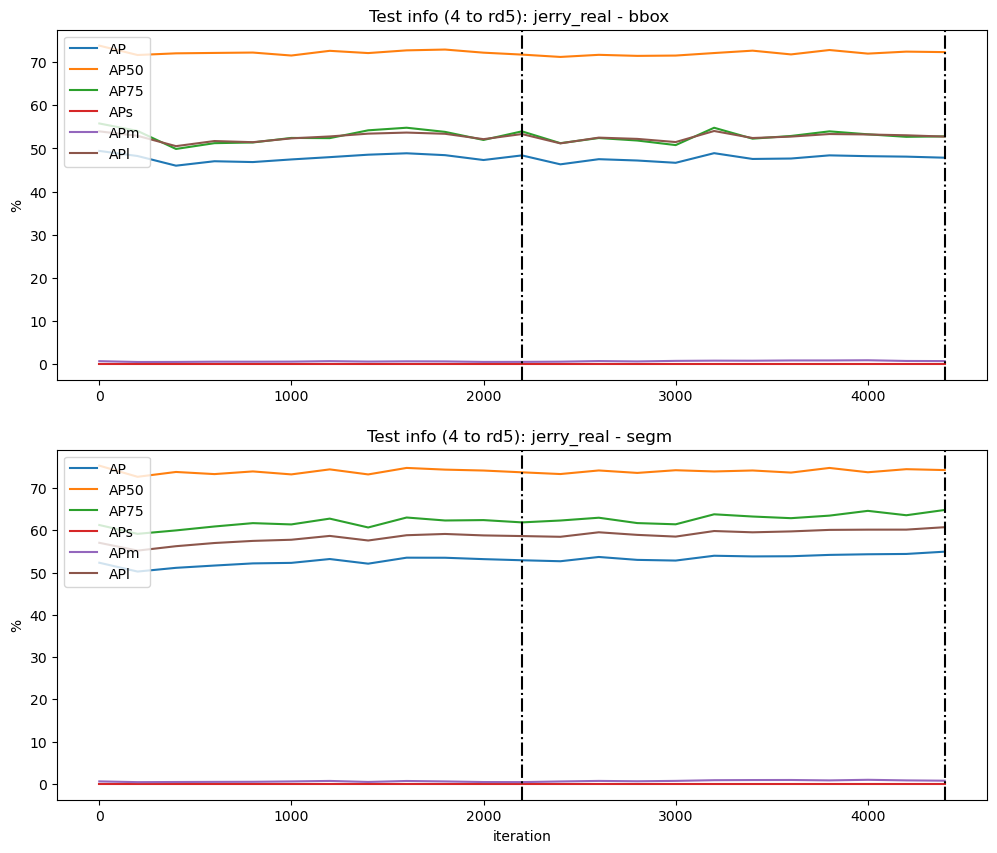

In [5]:
gatherCSVs(root_train,rnd,offset=4)
mergeCSVs(root_train,rnd,200,offset=4)
plotCSVs(root_train,rnd,offset=4,iter_event=[2200,4400])